Layer (type (var_name))                  Output Shape         Param #              Trainable
UNet3D (UNet3D)                          [1, 1, 16, 32, 32]   --                   True
├─Sequential (encoder1)                  [1, 16, 16, 32, 32]  --                   True
│    └─Conv3d (enc1conv1)                [1, 16, 16, 32, 32]  2,000                True
│    └─PReLU (enc1prelu1)                [1, 16, 16, 32, 32]  1                    True
├─Sequential (down1)                     [1, 32, 8, 16, 16]   --                   True
│    └─Conv3d (down1conv1)               [1, 32, 8, 16, 16]   4,096                True
│    └─PReLU (down1prelu1)               [1, 32, 8, 16, 16]   1                    True
├─Sequential (encoder2)                  [1, 32, 8, 16, 16]   --                   True
│    └─Conv3d (enc2conv1)                [1, 32, 8, 16, 16]   128,000              True
│    └─PReLU (enc2prelu1)                [1, 32, 8, 16, 16]   1                    True
│    └─Conv3d (enc2conv2)  

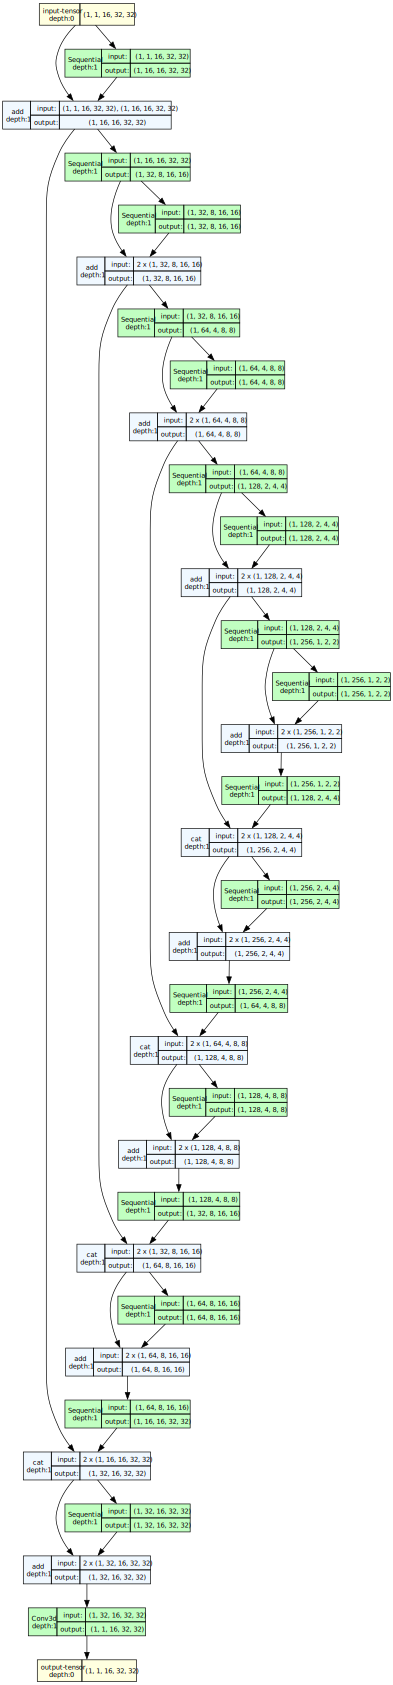

In [96]:
import torch

import torch.nn as nn

from collections import OrderedDict
from torchinfo import summary
from functools import reduce
from itertools import accumulate
from torchview import draw_graph

class UNet3D(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, blocks=[16, 32, 64, 128], verbose=False):
        super(UNet3D, self).__init__()

        self.blocks = blocks
        self.num_blocks = len(blocks)
        self.verbose = verbose

        # Encoder Modules
        for enc_id, block in enumerate(blocks, start=1):
            in_features = block if enc_id != 1 else in_channels
            setattr(
                self, f'encoder{enc_id}',
                UNet3D._block(in_features, block, name=f'enc{enc_id}', layers=min(enc_id, 3))
            )
        
        # Down Convs
        for down_id, block in enumerate(blocks, start=1):
            module_name = f'down{down_id}'
            setattr(
                self, module_name,
                UNet3D._block(block, block*2, size=2, stride=2, name=f'down{down_id}', layers=1)
            )
        
        # Bottleneck Module
        self.bottleneck = UNet3D._block(blocks[-1]*2, blocks[-1]*2, name="bottleneck", layers=3)

        # Upconv Layers
        for up_id, block in enumerate(blocks, start=1):
            in_features = block*2 if up_id == self.num_blocks else block*4
            module_name = f'up{up_id}'
            setattr(
                self, module_name,
                nn.Sequential(
                    OrderedDict([
                        (
                            f'{module_name}deconv',
                            nn.ConvTranspose3d(
                                in_features, block, kernel_size=2, stride=2,
                            )
                        ),
                        (f'{module_name}prelu', nn.PReLU())
                    ])
                )
                
            )

        # Decoder Modules
        for dec_id, block in enumerate(blocks, start=1):
            setattr(
                self, f'decoder{dec_id}',
                UNet3D._block(block*2, block*2, name=f'dec{dec_id}', layers=min(dec_id, 3))
            )
        
        # Output Layer
        self.output = nn.Conv3d(
            in_channels=blocks[0]*2, out_channels=out_channels, kernel_size=1,
        )

    def forward(self, x):
        # 1. Encoder Leg
        block_encodings = [None]
        for block_id, _ in enumerate(self.blocks, start=1):
            encoder = getattr(self, f'encoder{block_id}')
            down = getattr(self, f'down{block_id}')

            x = x + encoder(x)
            block_encodings.append(x)
            x = down(x)
        
        # 2. Apply Bottleneck
        x = x + self.bottleneck(x)

        if self.verbose: print(f'Bottleneck: {x.shape}')

        # 3. Decoder Leg
        for block_id in range(len(self.blocks), 0, -1):
            upconv = getattr(self, f'up{block_id}')
            decoder = getattr(self, f'decoder{block_id}')
            block_encoding = block_encodings[block_id]

            if self.verbose: print(f'Decoder {block_id} >--{x.shape=} encoder>--:{block_encoding.shape}')
            x = upconv(x)
            if self.verbose: print(f'Decoder {block_id} upconv-->{block_encoding.shape}')

            x = torch.cat((block_encoding, x), dim=1)
            x = x + decoder(x)
        
        # 4. Output
        output = self.output(x)

        return output

    @staticmethod
    def _block(in_channels, features, name, size=5, stride=1, layers=1):
        def make_item(args):
            index, in_c = args
            return list(filter(
                lambda v: v != None,
                [
                    (
                        f'{name}conv{index}',
                        nn.Conv3d(
                            in_channels=in_c,
                            out_channels=features,
                            kernel_size=size,
                            stride=stride,
                            padding=(size - stride)//2, # TODO
                            bias=False,
                        )
                    ),
                    # (f'{name}prelu{index}', nn.PReLU()) if index != layers else None,
                    (f'{name}prelu{index}', nn.PReLU()),
                ]
            ))

        return nn.Sequential(
            OrderedDict(chain(*map(
                make_item,
                zip(
                    range(1, layers+1), # index arg
                    [in_channels, *([features] * (layers - 1))], # in_c arg
                )
            )))
        )

input_shape = (16, 32, 32)
batch_size = 1
inp = torch.randn((batch_size, 1, *input_shape))

model = UNet3D(verbose=False)
print(
    summary(
        model=model,
        input_size=(batch_size, 1, *input_shape),
        # col_names=["input_size", "output_size", "num_params", "trainable"],
        col_names=["output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        depth=2,
    )
)

graph = draw_graph(
    model, 
    input_size=(1, 1, *input_shape), 
    depth=1,
)

# View Model Architecture
graph.visual_graph